In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten 28x28 to 784
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


In [10]:
# Data exploration
len(train_dataset)
x0, y0 = train_dataset[0]
x0.shape, y0
X = torch.stack([x for x, _ in train_dataset])  # shape: (60000, 784)
y = torch.tensor([y for _, y in train_dataset])  # shape: (60000,)
print(X.shape)
print(y.shape)

torch.Size([60000, 784])
torch.Size([60000])


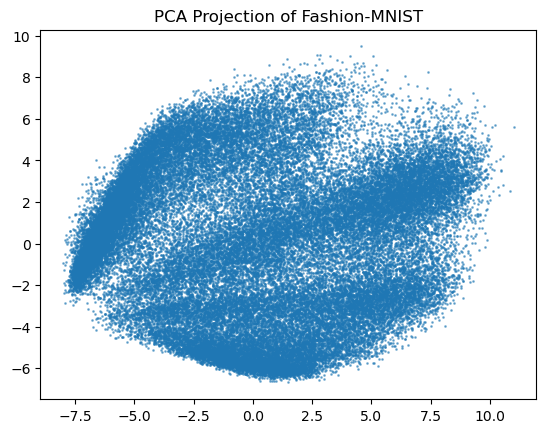

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Z_pca = pca.fit_transform(X.numpy())
Z_pca.shape  # should be (60000, 2)

plt.scatter(Z_pca[:, 0], Z_pca[:, 1], s=1, alpha=0.5)
plt.title("PCA Projection of Fashion-MNIST")
plt.show()

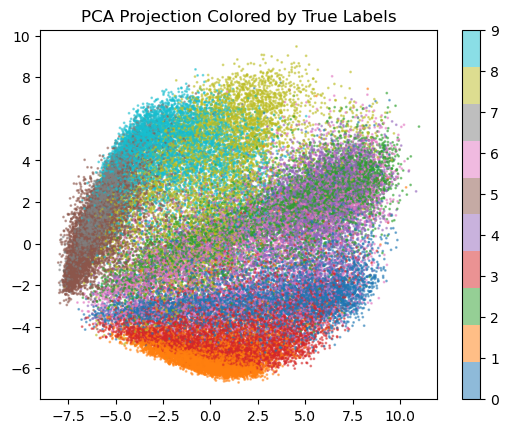

In [16]:
plt.scatter(Z_pca[:, 0], Z_pca[:, 1], c=y, cmap='tab10', s=1, alpha=0.5)
plt.title("PCA Projection Colored by True Labels")
plt.colorbar()
plt.show()


In [24]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [26]:
ae = Autoencoder()

criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
num_epochs = 20

for epoch in range(num_epochs):
    for x_batch, _ in train_loader:
        x_hat = ae(x_batch)
        loss = criterion(x_hat, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0369
Epoch 2, Loss: 0.0326
Epoch 3, Loss: 0.0329
Epoch 4, Loss: 0.0311
Epoch 5, Loss: 0.0310
Epoch 6, Loss: 0.0283
Epoch 7, Loss: 0.0315
Epoch 8, Loss: 0.0295
Epoch 9, Loss: 0.0318
Epoch 10, Loss: 0.0334
Epoch 11, Loss: 0.0294
Epoch 12, Loss: 0.0313
Epoch 13, Loss: 0.0280
Epoch 14, Loss: 0.0283
Epoch 15, Loss: 0.0320
Epoch 16, Loss: 0.0286
Epoch 17, Loss: 0.0281
Epoch 18, Loss: 0.0292
Epoch 19, Loss: 0.0298
Epoch 20, Loss: 0.0303


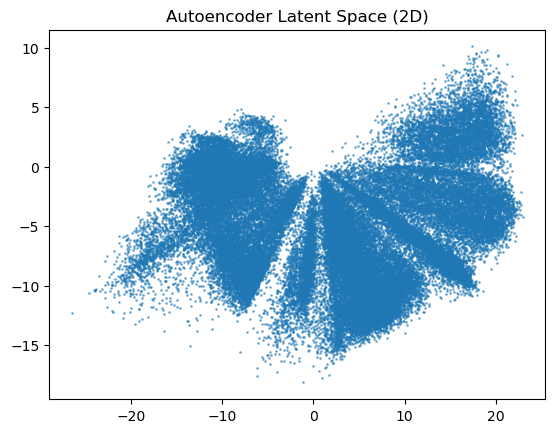

In [28]:
with torch.no_grad():
    Z_ae = ae.encoder(X).numpy()
plt.scatter(Z_ae[:, 0], Z_ae[:, 1], s=1, alpha=0.5)
plt.title("Autoencoder Latent Space (2D)")
plt.show()



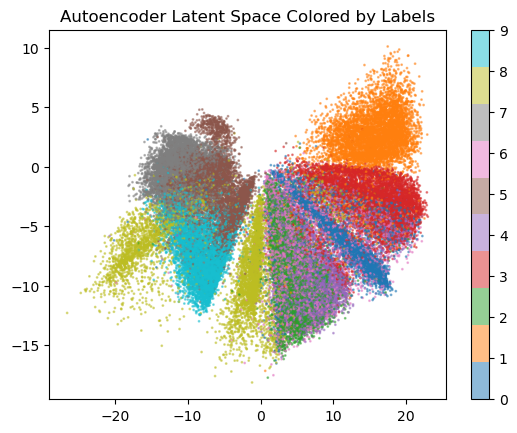

In [29]:
plt.scatter(Z_ae[:, 0], Z_ae[:, 1], c=y, cmap='tab10', s=1, alpha=0.5)
plt.title("Autoencoder Latent Space Colored by Labels")
plt.colorbar()
plt.show()